In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import shap

c:\Tripleten\Proyectos\credit_scoring\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Configuración visual
sns.set_style("whitegrid")

In [3]:
# --- 1. CARGA DE DATOS ---
try:
    df = pd.read_csv('datasets/german_credit_data.csv')
    print("✅ Dataset cargado correctamente.")
except FileNotFoundError:
    print("❌ Error: No se encuentra el archivo. Verifica que esté dentro de la carpeta 'datasets'")

✅ Dataset cargado correctamente.


In [4]:
# Ver nombres de columnas
print(df.columns)

# Ver las primeras filas para entender la estructura
display(df.head())

Index(['Unnamed: 0', 'Age', 'Sex', 'Job', 'Housing', 'Saving accounts',
       'Checking account', 'Credit amount', 'Duration', 'Purpose', 'Risk'],
      dtype='object')


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [5]:
# --- 2. PREPROCESAMIENTO ---
# Llenar nulos
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

if 'Unnamed: 0' in df.columns:
    df = df.drop('Unnamed: 0', axis=1)

# Target: 1 (Bad/Riesgo), 0 (Good/Paga)
df['Target'] = df['Risk'].map({'good': 0, 'bad': 1})
X = df.drop(['Risk', 'Target'], axis=1)
y = df['Target']

# One-Hot Encoding
X = pd.get_dummies(X, drop_first=True)

In [6]:
# --- 3. MODELADO ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Modelo RandomForest
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric


=== METRICAS DEL MODELO ===
🚀 ROC-AUC Score: 0.74 (Capacidad de predicción)


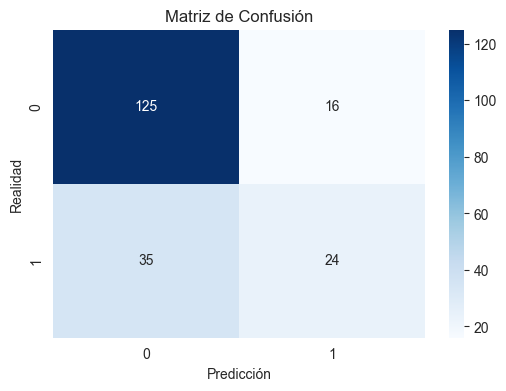

In [8]:
# --- 4. RESULTADOS ---
print("\n=== METRICAS DEL MODELO ===")
auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(f"🚀 ROC-AUC Score: {auc:.2f} (Capacidad de predicción)")

# Matriz de Confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, model.predict(X_test)), annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.ylabel('Realidad')
plt.xlabel('Predicción')
plt.show()

Generando gráfico de importancia de variables...


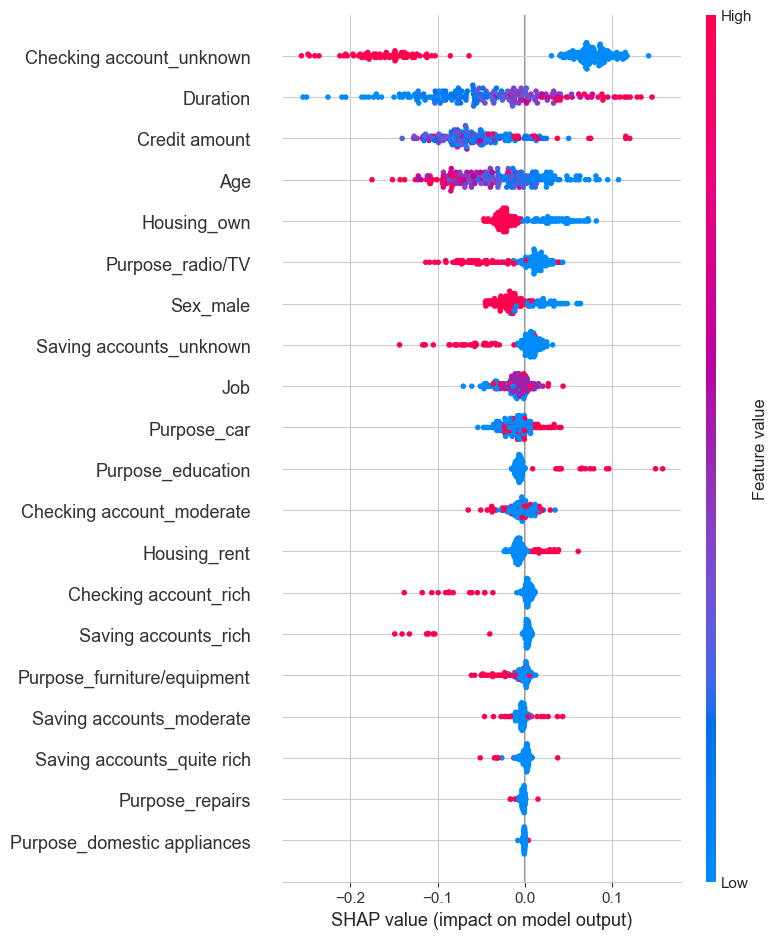

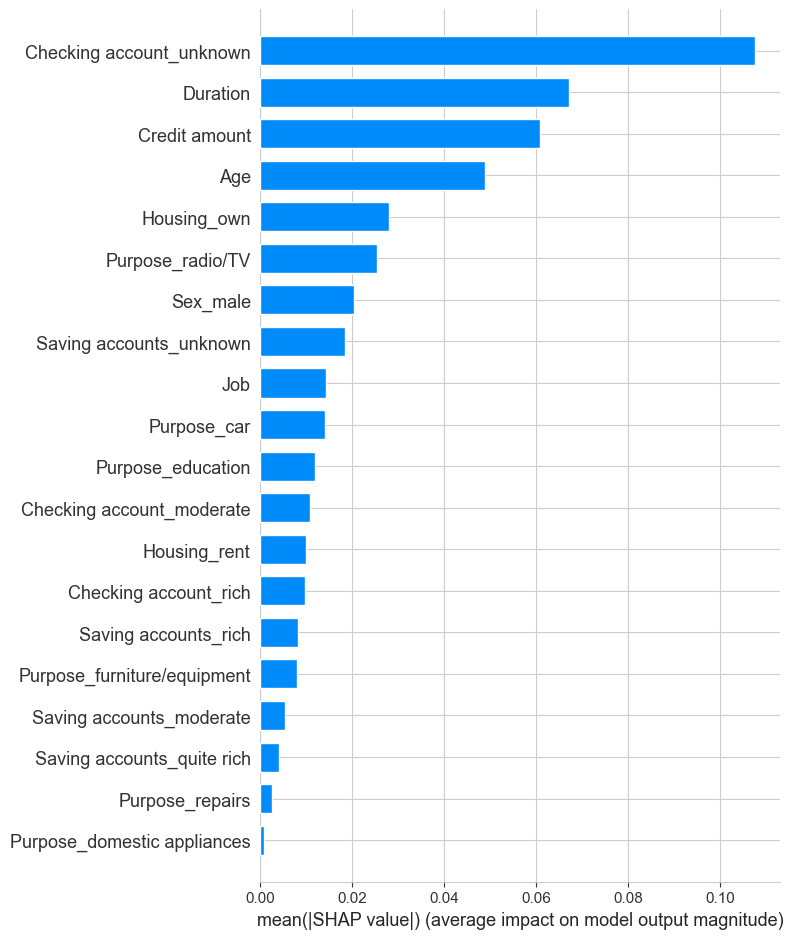

In [11]:
# --- 5. EXPLICACIÓN (SHAP) ---
print("Generando gráfico de importancia de variables...")

explainer = shap.TreeExplainer(model)
# check_additivity=False evita errores de precisión matemática en algunos entornos
shap_values = explainer.shap_values(X_test, check_additivity=False)

# Lógica inteligente para detectar el formato (Lista vs Cubo)
if isinstance(shap_values, list):
    # Formato Clásico: Lista de [Clase0, Clase1] -> Usamos Clase 1 (Riesgo)
    vals_to_plot = shap_values[1]
elif len(shap_values.shape) == 3:
    # Formato Nuevo: Cubo [Filas, Columnas, Clases] -> Cortamos para la Clase 1
    vals_to_plot = shap_values[:, :, 1]
else:
    # Formato simple (ya es 2D)
    vals_to_plot = shap_values

# Graficar
shap.summary_plot(vals_to_plot, X_test)

shap.summary_plot(vals_to_plot, X_test, plot_type="bar")